In [1]:
import torch
import numpy as np
from IPython.display import clear_output
import random
import os

In [2]:
def seed_everything(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    os.environ['PYTHONHASHSEED'] = str(seed_value)
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True

seed = 12
seed_everything(seed)

In [3]:
# numpy world

x = np.arange(16).reshape(4, 4)

print("X :\n %s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", np.dot(x, x.T))
print("mean over cols :\n%s" % (x.mean(axis=-1)))
print("cumsum of cols :\n%s" % (np.cumsum(x, axis=0)))

X :
 [[ 0  1  2  3]
 [ 4  5  6  7]
 [ 8  9 10 11]
 [12 13 14 15]]
add 5 :
[[ 5  6  7  8]
 [ 9 10 11 12]
 [13 14 15 16]
 [17 18 19 20]]
X*X^T  :
 [[ 14  38  62  86]
 [ 38 126 214 302]
 [ 62 214 366 518]
 [ 86 302 518 734]]
mean over cols :
[ 1.5  5.5  9.5 13.5]
cumsum of cols :
[[ 0  1  2  3]
 [ 4  6  8 10]
 [12 15 18 21]
 [24 28 32 36]]


In [4]:
# pytorch world

x = np.arange(16).reshape(4, 4)

x = torch.from_numpy(x).type(torch.FloatTensor) #or torch.arange(0,16).view(4,4)

print("X :\n%s" % x)
print("add 5 :\n%s" % (x + 5))
print("X*X^T  :\n", torch.matmul(x, x.transpose(1, 0)))
print("mean over cols :\n", torch.mean(x, dim=-1))
print("cumsum of cols :\n", torch.cumsum(x, dim=0))

X :
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.],
        [12., 13., 14., 15.]])
add 5 :
tensor([[ 5.,  6.,  7.,  8.],
        [ 9., 10., 11., 12.],
        [13., 14., 15., 16.],
        [17., 18., 19., 20.]])
X*X^T  :
 tensor([[ 14.,  38.,  62.,  86.],
        [ 38., 126., 214., 302.],
        [ 62., 214., 366., 518.],
        [ 86., 302., 518., 734.]])
mean over cols :
 tensor([ 1.5000,  5.5000,  9.5000, 13.5000])
cumsum of cols :
 tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  6.,  8., 10.],
        [12., 15., 18., 21.],
        [24., 28., 32., 36.]])


## NumPy vs Pytorch

Numpy и Pytorch не требуют описания статического графа вычислений. 

Можно отлаживаться с помощью pdb или просто print.

API несколько различается:

```
x.reshape([1,2,8]) -> x.view(1,2,8)
x.sum(axis=-1) -> x.sum(dim=-1)
x.astype('int64') -> x.type(torch.int64)
```


Легко конвертировать между собой:

```
torch.from_numpy(npx) -- вернет Tensor
tt.numpy() -- вернет Numpy Array
```

Преобразовать тензор из одного числа в обычное питоновское число:
```
torch.tensor([1]).item() -> 1
```


Если что:
- смотрите документацию https://pytorch.org/docs/
- гуглите (Stackoverflow/tutorials)

In [5]:
x = torch.linspace(0, 2 * np.pi, 16, dtype=torch.float64)

#Mini-task: compute a vector of sin^2(x) + cos^2(x)
out = torch.sin(x)**2 + torch.cos(x)**2

print(out.numpy())

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


# Automatic gradients

У каждого тензора в Pytorch есть флаг `requires_grad`, который отвечает за автоматическое вычисление градиентов:

1. Создать переменную: `a = torch.tensor(..., requires_grad=True)`

2. Определить какую-нибудь дифференцируемую функцию `loss = whatever(a)`

3. Запросить обратный проход `loss.backward()`

4. Градиенты будут доступны в `a.grads`


Есть два важных отличия Pytorch от Theano/TF:

1. Функцию ошибки можно изменять динамически, например на каждом минибатче.

2. После вычисления `.backward()` градиенты сохраняются в `.grad` каждой задействованной переменной, при повторных вызовах градиенты суммируются. Это позволяет использовать несколько функций ошибок или виртуально увеличивать batch_size. Поэтому, после каждого шага оптимизатора градиенты стоит обнулять.



## Leaf vs Non-leaf Variable:
```
x = torch.tensor([1., 2., 3., 4.], requires_grad=True))  # leaf tensor
y = x + 1  # not a leaf variable
```

Градиенты будут сохранены и доступны для использования только для `leaf tensor`.
Такое поведение по-умолчанию сделано ради экономии памяти. Все тензоры с флагом `requires_grad = False` считаются`leaf tensors` по умолчанию.


Обратите внимание, что вычисление градиентов работает только для тензоров с вещественным типом данных:

In [6]:
# # will not work
# x = torch.tensor([1, 2, 3, 4], requires_grad=True)


Чтобы выставить флаг `requires_grad=False` и выключить автоматическое вычисление градиентов для нескольких тензоров, можно использовать `with torch.no_grad()` или `detach`:

In [7]:
x = torch.tensor([1.], requires_grad=True)
y = x**2
print(x.requires_grad)
print(y.requires_grad)

with torch.no_grad():
    z = torch.exp(x)
    print(z.requires_grad)
    
# detach from the graph
w = torch.log(x).detach()
print(w.requires_grad)

True
True
False
False


Рассмотрим пример линейной регрессии на датасете Boston

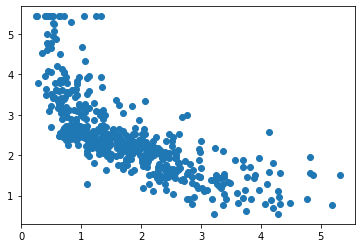

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston

x, y = load_boston(return_X_y=True)

#select one column for simplicity. 
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

plt.scatter(x, y)

In [9]:
# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# все тензоры являются leaf-tensors
# x и y не требуют вычисления градиентов
for vv in [w, b, x, y]:
    print(vv.is_leaf, vv.requires_grad)

True True
True True
True False
True False


In [10]:
#try out gradients
y_pred = w * x + b
loss = torch.mean((y_pred - y)**2)

loss.backward()

#now w.grad is a tensor containing gradient of L w.r.t. w

print("dL/dw = \n", w.grad)
print("dL/db = \n", b.grad)

# no gradients for tensors with requires_grad=False
# and non-leaf tensors
print("Non-Leaf x dL/dx = \n", x.grad)
print("Non-Leaf loss dL/dpred = \n", y_pred.grad)

dL/dw = 
 tensor([-7.2240])
dL/db = 
 tensor([-4.9048])
Non-Leaf x dL/dx = 
 None
Non-Leaf loss dL/dpred = 
 None


/home/mikhail/.local/lib/python3.6/site-packages/torch/tensor.py:746: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the gradient for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations.
  warnings.warn("The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad "


## Градиенты промежуточных вершин

В графе, который мы описали `x` и `y_pread` не являются листовыми вершинами. По умолчанию для них не сохраняются градиенты.

Для промежуточных вершин мы можем запросить сохранение градиентов с помощью функции `.retain_grad()`.


In [11]:
y_pred = w * x + b

# check this:
y_pred.retain_grad()

loss = torch.mean((y_pred - y)**2)
loss.backward()

print("Non-Leaf loss dL/dpred = \n", y_pred.grad[:10])

Non-Leaf loss dL/dpred = 
 tensor([-0.0103, -0.0093, -0.0149, -0.0144, -0.0156, -0.0123, -0.0099, -0.0117,
        -0.0071, -0.0081])


# Линейная регрессия

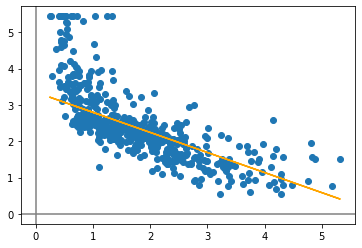

loss =  0.49713197350502014
Done!


In [12]:
from IPython.display import clear_output

for i in range(100):
    
    #compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    
    # backprop
    loss.backward()
    print(w.grad)
    # gradient descent step for weights
    # take alpha about 0.1
    w.data -= w.grad * 0.1
    b.data -= b.grad * 0.1
    
    #zero gradients
    w.grad.zero_()
    b.grad.zero_()
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5==0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(),y.numpy())
        plt.plot(x.numpy(),y_pred.data.numpy(),color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

# Optimizers

В этом примере мы пользовались простым правилом для градиентного спуска:
  
$$\theta^{n+1} = \theta^{n} - \alpha \nabla_{\theta}L$$


Единственным параметром в нем является $\alpha$ -- это `learning_rate`.

На практике часто используют различные модификации (например _Momentum_):

$$\theta^{n+1} = \theta^{n} - U^{n}\\
U^{n} = \gamma U^{n-1} + \alpha \nabla_{\theta}(L)
$$

Хороший обзор алгоритмов оптимизации для сетей можно посмотреть [тут](http://ruder.io/optimizing-gradient-descent/).



Pytorch предоставляет практически все широкораспространненные оптимизаторы:    
http://pytorch.org/docs/master/optim.html




Оптимизаторы удобны в использовании:

- требуется указать список переменных для оптимизации
- `opt.step()` применяет `update` ($U^{n}$) к весам
- `opt.zero_grad()` сбрасывает градиенты





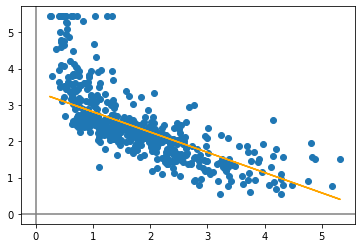

loss =  0.49351754784584045
Done!


In [13]:
# get data
x, y = load_boston(return_X_y=True)
x = x[:, -1] / x[:, -1].std()
y = y / y.std()

# data tensors
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# model tensors
w = torch.zeros(1, requires_grad=True)
b = torch.zeros(1, requires_grad=True)

# define optimizer
opt = torch.optim.RMSprop([w, b], lr=0.1)

for i in range(100):
    # compute loss
    y_pred = w * x  + b
    loss = torch.mean((y_pred - y)**2)
    
    # backprop and gradient descent
    loss.backward()
    opt.step()
    opt.zero_grad()
    
    #the rest of code is just bells and whistles
    if (i + 1) % 5 == 0:
        #draw linear regression prediction vs data
        clear_output(True)
        plt.axhline(0, color='gray')
        plt.axvline(0, color='gray')
        plt.scatter(x.numpy(), y.numpy())
        plt.plot(x.numpy(), y_pred.data.numpy(), color='orange')
        plt.show()

        print("loss = ", loss.item())
        if loss.item() < 0.5:
            print("Done!")
            break

## Highlevel-API 

При работе с нейронными сетями становится неудобно контролировать переменные с весами по-отдельности. Pytorch предоставляет высокоуровневый API для моделей http://pytorch.org/docs/master/nn.html#torch.nn.Module.


Чтобы воспользоваться моделью необходимо отнаследоваться от torch.nn.Module, определить слои и описать `forward`, `backward` будет вычислен автоматически.


Для демонстрации снова воспользуемся MNIST'ом.

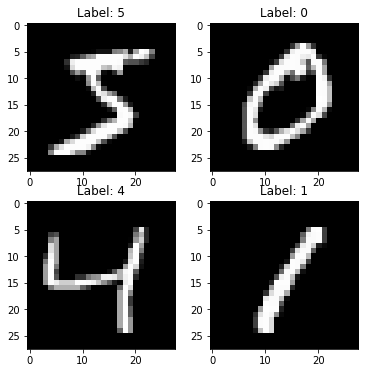

In [14]:
# MNIST again
from util import load_mnist
X_train, y_train, X_val, y_val, X_test, y_test = load_mnist(flatten=True)

plt.figure(figsize=[6, 6])
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.title("Label: %i" % y_train[i])
    plt.imshow(X_train[i].reshape([28, 28]), cmap='gray');

In [15]:
# Higher-level API:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, hidden_size=40):
        super(Net, self).__init__()
        # here you construct weights for linear layers 
        self.fc1 = nn.Linear(28*28, hidden_size)
        self.fc2 =  nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 10)
        
    def forward(self, x):
        # here you describe usage of layers
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        # check log_softmax signature
        return F.log_softmax(x, dim=-1)
    # backward function computes automaticaly

In [16]:
# model interface:
model = Net()
tt = torch.from_numpy(X_train[:10, :].astype(np.float32))
output = model(tt)

print('Model outputs: \n', output)
# TODO: получите вероятности из output c помощью функций из torch
# hint: см документацию к log_softmax
probs = torch.exp(output)
print('Probs: \n', probs)

# TODO: получите предсказание из output c помощью функций из torch
pred = torch.argmax(output, axis = 1)
print('Pred: \n', pred.data.numpy())
print('Truth: \n', y_train[:10])

Model outputs: 
 tensor([[-2.2579, -2.1804, -2.2898, -2.2476, -2.4807, -2.3905, -2.2589, -2.1950,
         -2.3788, -2.3887],
        [-2.2345, -2.1947, -2.3159, -2.2264, -2.4980, -2.4293, -2.2110, -2.1920,
         -2.3817, -2.3978],
        [-2.3042, -2.1411, -2.2615, -2.2355, -2.5032, -2.4032, -2.2523, -2.2074,
         -2.3526, -2.4193],
        [-2.2577, -2.2029, -2.2842, -2.2487, -2.4630, -2.4100, -2.2203, -2.1986,
         -2.3918, -2.3910],
        [-2.2601, -2.2099, -2.2850, -2.2216, -2.4854, -2.4255, -2.2305, -2.1830,
         -2.3971, -2.3767],
        [-2.2506, -2.1762, -2.2520, -2.2318, -2.4962, -2.3570, -2.3039, -2.1847,
         -2.3842, -2.4417],
        [-2.2515, -2.1767, -2.2886, -2.2313, -2.4608, -2.3867, -2.2646, -2.2304,
         -2.3680, -2.4056],
        [-2.2391, -2.1801, -2.2861, -2.2386, -2.4819, -2.3656, -2.2703, -2.1820,
         -2.4057, -2.4263],
        [-2.2520, -2.1926, -2.2878, -2.2427, -2.4722, -2.4044, -2.2247, -2.2173,
         -2.3786, -2.3955],
  

Тренировка сети

Для тренировки сети нам требуется 
- итератор по данным
- функция тренировки (прогон по данным, вычисление и применение градиентов)
- функция валидации (прогон по тестовым данным, вычисление метрик)

In [17]:
from IPython.display import clear_output
from tqdm import trange

# функция для итераций по минибатчам, из первого семинара
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in trange(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [18]:
def train(model, optimizer, batchsize=32):
    loss_log = []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
    return loss_log


# TODO: написать функцию для валидации по X_val, y_val
# hint: optimizer не нужен
def test(model):
    loss_log = []
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=batchsize):
            data = torch.from_numpy(x_batch.astype(np.float32))
            target = torch.from_numpy(y_batch.astype(np.int64))
            output = model(data)
            loss = F.nll_loss(output, target)
            loss = loss.item()
            loss_log.append(loss)
    
    return loss_log

Для отслеживания процедуры тренировки построить график

In [19]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.plot(np.arange(len(train_history)), train_history, color='red', label='train')
    epoch_samples_num = len(train_history)/len(val_history)
    plt.plot(np.arange(epoch_samples_num-1, len(train_history), epoch_samples_num), val_history,
             color='blue', label='val', marker='o')
    plt.title(title)
    plt.xlabel('train_steps')
    plt.ylabel(title)
    plt.legend()
    plt.show()

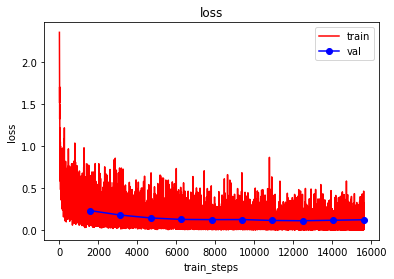

In [20]:
train_log = []
val_log = []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

for epoch in range(10):
    train_loss = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)
    
    val_loss = np.mean(test(model))
    val_log.append(val_loss)
    # TODO: график train_loss vs train_steps с точками val_loss vs trained_steps
    
    # use your plot_history()
    clear_output(wait=True)
    plot_history(train_log, val_log)
    # hint: train_log and val_log may contain data with different shapes

## Метрики

Logloss -- величина, которую трудно интерпретировать. 
Для отслеживания тренировки и сравнения моделей удобнее наблюдать за интерпретируемыми метриками, например точностью (accuracy)

Модифицируйте код train/test функций так, чтобы помимо ошибки подсчитывалась точность за батч:

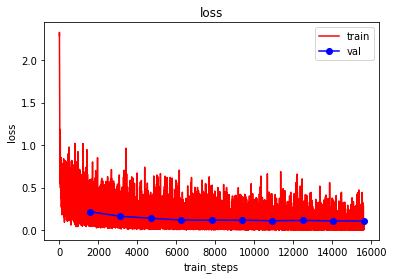

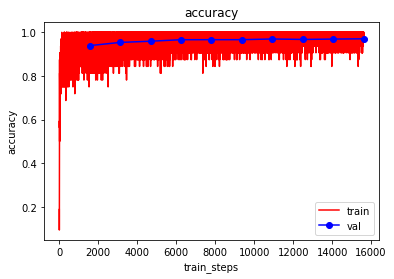

In [21]:
# TODO: добавьте подсчет точности
def train(model, optimizer, batchsize=32):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in iterate_minibatches(X_train, y_train, batchsize=batchsize, shuffle=True):
        # data preparation
        data = torch.from_numpy(x_batch.astype(np.float32))
        target = torch.from_numpy(y_batch.astype(np.int64))

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        # compute gradients
        loss.backward()
        # make a step
        optimizer.step()
        loss = loss.item()
        loss_log.append(loss)
        preds = torch.argmax(output, dim=-1)
        acc_log.append(torch.mean((preds==target).type(torch.float)))
    return loss_log, acc_log


# TODO: добавьте подсчет точности:
def test(model):
    loss_log, acc_log = [], []
    
    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in iterate_minibatches(X_val, y_val, batchsize=batchsize):
            data = torch.from_numpy(x_batch.astype(np.float32))
            target = torch.from_numpy(y_batch.astype(np.int64))
            output = model(data)
            loss = F.nll_loss(output, target)
            loss = loss.item()
            loss_log.append(loss)
            preds = torch.argmax(output, dim=-1)
            acc_log.append(torch.mean((preds==target).type(torch.float)))
    return loss_log, acc_log


train_log, train_acc_log = [], []
val_log, val_acc_log = [], []

model = Net()
opt = torch.optim.RMSprop(model.parameters(), lr=0.001)
batchsize = 32

for epoch in range(10):
    # train
    train_loss, train_acc = train(model, opt, batchsize=batchsize)
    train_log.extend(train_loss)
    train_acc_log.extend(train_acc)
    # test
    val_loss, val_acc = test(model)
    val_log.append(np.mean(val_loss))
    val_acc_log.append(np.mean(val_acc))
    
    # plot all metrics (loss and acc for train/val)
    clear_output(wait=True)
    plot_history(train_log, val_log)
    plot_history(train_acc_log, val_acc_log, 'accuracy')
    

## Fine Tuning
Для многих прикладных задач не существует больших датасетов с хорошей разметкой. 
Поэтому распространенным приемом является тренировка на похожем, но большом датасете и доучивание сети на целевом.

Такой прием называют **Transfer Learning** или **Finetuning**.

В сверточных сетях для классификации выделяют две части:
- тело сети -- это набор сверток и пулингов (convolutions and poolings)
- голову -- это MLP (набор полносвязных слоев) после которых делается softmax и получаются вероятности разных классов.


Вычислительно простым вариантом finetuning является переучивание головы сети.


Нам потребуется [предобученная модель](http://pytorch.org/docs/master/torchvision/datasets.html#torchvision-datasets) и датасет для нашей задачи.

Предлагется воспользоваться моделью для ImageNet и датасетом  https://download.pytorch.org/tutorial/hymenoptera_data.zip


В датасете содержатся картинки двух классов (`ants` и `bees`) разных размеров.

In [22]:
# ! wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# ! unzip ./hymenoptera_data.zip

Загрузчик данных -- одна из важных компонент для эффективного обучения нейронных сетей:
асинхронная загрузка и быстрая предобработка важны для полного использования GPU.

Для курсовых проектов рекомендуется ознакомиться и использовать [Pytorch Dataset](http://pytorch.org/tutorials/beginner/data_loading_tutorial.html#dataset-class)

Пример использования:

In [23]:
%matplotlib inline
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os


data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

use_gpu = torch.cuda.is_available()
plt.ion()

In [24]:
dataset_sizes

{'train': 244, 'val': 153}

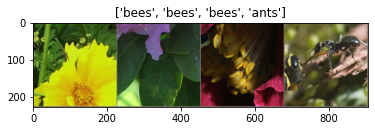

In [25]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.1)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [26]:
# обратите внимание на сохранение лучшей версии весов сети
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for data in dataloaders[phase]:
                # get the inputs
                inputs, labels = data

                if use_gpu:
                    inputs = inputs.cuda()
                    labels = labels.cuda()

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                # backward + optimize only if in training phase
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                # statistics
                running_loss += loss.item()
                running_corrects += torch.sum(preds == labels).type(torch.float)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()
        
        time_elapsed = time.time() - since
        print('Elapsed {:.0f}m {:.0f}s\n'.format(time_elapsed // 60, time_elapsed % 60))

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [27]:
# torchvision содержит ряд моделей с претрейненными весами:
[m for m in dir(models) if not m.startswith('_')]

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 'squeezenet1_1',
 'utils',
 'vgg',
 'vgg11',
 'vgg11_bn',
 'vgg13',
 'vgg13_bn',
 'vgg16',
 'vgg16_bn',
 'vgg19',
 'vgg19_bn',
 'video',
 'wide_resnet101_2',
 'wide_resnet50_2']

In [28]:
model_ft = models.resnet18(pretrained=True)
# hint: вы можете изучить устройство любого объекта в python пользуясь интерактивностью интерпретатора и методом dir()
# Список слоев модели можно получить с помощью обхода
# for x in model_ft.named_modules():
#    print(x[0], x[1])

# TODO: подмените в модели последний слой, чтобы она работала для двух классов

model_ft.fc = nn.Linear(model_ft.fc.in_features, 2)

# TODO: выберите, какие параметры дообучать. Результат получается лучше если дообучать всё или только последний слой? Почему?
# например, выключить обучение всех параметров можно при помощи этого кода:
# for params in model_ft.parameters():
#     params.requires_grad = False 

params_to_train = model_ft.fc.parameters()
#params_to_train = model_ft.parameters()
# use GPU if you have it
if use_gpu:
    model_ft = model_ft.cuda()

# loss
criterion = nn.CrossEntropyLoss()

# Create optimizer on the selected parameters
optimizer_ft = optim.SGD(params_to_train, lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [29]:
model_ft = train_model(
    model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)
# если всё сделано правильно, то точность на валидации должна быть больше 94%

Epoch 0/24
----------


/home/mikhail/.local/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 0.1809 Acc: 0.6148
val Loss: 0.0626 Acc: 0.9085
Elapsed 0m 2s

Epoch 1/24
----------
train Loss: 0.1358 Acc: 0.7377
val Loss: 0.0530 Acc: 0.9346
Elapsed 0m 3s

Epoch 2/24
----------
train Loss: 0.1211 Acc: 0.7992
val Loss: 0.0542 Acc: 0.9216
Elapsed 0m 4s

Epoch 3/24
----------
train Loss: 0.1412 Acc: 0.7787
val Loss: 0.0456 Acc: 0.9412
Elapsed 0m 5s

Epoch 4/24
----------
train Loss: 0.1177 Acc: 0.7910
val Loss: 0.0447 Acc: 0.9412
Elapsed 0m 6s

Epoch 5/24
----------
train Loss: 0.0928 Acc: 0.8402
val Loss: 0.0487 Acc: 0.9346
Elapsed 0m 8s

Epoch 6/24
----------
train Loss: 0.1062 Acc: 0.8197
val Loss: 0.0466 Acc: 0.9346
Elapsed 0m 9s

Epoch 7/24
----------
train Loss: 0.0818 Acc: 0.8689
val Loss: 0.0435 Acc: 0.9412
Elapsed 0m 10s

Epoch 8/24
----------
train Loss: 0.1042 Acc: 0.7992
val Loss: 0.0435 Acc: 0.9346
Elapsed 0m 11s

Epoch 9/24
----------
train Loss: 0.0755 Acc: 0.8934
val Loss: 0.0419 Acc: 0.9477
Elapsed 0m 13s

Epoch 10/24
----------
train Loss: 0.0864 Acc: 0.

Обучаем все слои:

Best val Acc: 0.947712

Обучаем только последний слой:

Best val Acc: 0.960784, тк датасет маленький то разумнее размораживать только последний слой, меньше вероятность оверфита

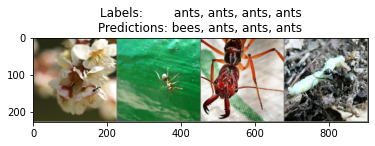

In [30]:
# TODO: напишите функцию, прогоняющую модель на нескольких примерах из валидационной выборки
# Отобразите картинки и предсказания



def visualize(model, num_images=10):

    inputs, classes = next(iter(dataloaders['val']))
    out = torchvision.utils.make_grid(inputs)
    model.eval()
    with torch.no_grad():
        if use_gpu:
            inputs = inputs.cuda()
        logits = model(inputs)
        preds = torch.argmax(logits, dim=-1)
    # Make a grid from batch
    
    title = 'Labels:        '+ ', '.join([class_names[x] for x in classes]) + '\nPredictions: ' + ', '.join([class_names[x] for x in preds])
    imshow(out, title=title)
            
visualize(model_ft)